In [1]:
if "running_all" not in globals():
    from ipywidgets import widgets
    matrices = ["bcsstk18", "cbuckle", "ct20stif", "raefsky4", "vanbody"]
    b = widgets.Button(description="Run over all matrices", button_style="success")
    output = widgets.Output()

    display(b, output)

    def run_over_all_matrices(button):
        global running_all
        global matrix
        running_all = True
        with output:
            for matrix in matrices:
                print(f"Running {matrix}...")
                %run ./protection_vis.ipynb # will output at this cell rather than later
            print("Finished!")
    b.on_click(run_over_all_matrices)

Button(button_style='success', description='Run over all matrices', style=ButtonStyle())

Output()

In [2]:
if "running_all" not in globals():
    matrix = "bcircuit"  # manually set to run over one matrix
matrix

'bcircuit'

In [3]:
from scipy.sparse.linalg import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from io_utils import load_matrices_from_dir, load_models

  Activating project at `~/My_Drive/Research/code/Dynamic-Selective-Protection/Pcg`


In [4]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<68902x68902 sparse matrix of type '<class 'numpy.float64'>'
	with 375558 stored elements in Compressed Sparse Column format>

In [5]:
mat_errorfree_iters = {
    "bcsstk18": 432,
    "cbuckle": 341,
    "ct20stif": 364,
    "raefsky4": 79,
    "vanbody": 491,
    "Pres_Poisson": 72,
    "Na5": 101,
    "bcircuit": 48,
}
errorfree_iterations = mat_errorfree_iters[matrix]

In [6]:
chosen_models = {
    "bcsstk18": "KNeighborsRegressor",
    "cbuckle": "RandomForestRegressor",
    "ct20stif": "XGBRegressor",
    "raefsky4": "RandomForestRegressor",
    "vanbody": "KNeighborsRegressor",
    "Pres_Poisson": "XGBRegressor",
    "Na5": "XGBRegressor",
    "bcircuit": "XGBRegressor",
}
model_path = f"./models/{matrix}/best_{chosen_models[matrix]}.pkl"
model = load_models([model_path])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.09515780413625062, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=741, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [7]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                              for i in range(errorfree_iterations)])
df = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df["output"] = model.predict(df[["i", "2norm"]].to_numpy())
df.head()

,i,2norm,rowid,output
0,0.0,24.509351,0.0,1.638073
1,1.0,24.509351,0.0,3.142300
2,2.0,24.509351,0.0,5.951646
3,3.0,24.509351,0.0,5.101652
4,4.0,24.509351,0.0,2.540766


In [8]:
max_2norm = df["2norm"].max()
spaced_2norms = np.geomspace(1e-6, max_2norm, num=1000)
iter_norm_pairs_spaced = np.array([[i, n, p] for p, n in enumerate(spaced_2norms)
                                       for i in range(errorfree_iterations)])
df_spaced = pd.DataFrame(iter_norm_pairs_spaced, columns=["i", "2norm", "rowid"])
df_spaced["output"] = model.predict(df_spaced[["i", "2norm"]].to_numpy())
df_spaced.head()

,i,2norm,rowid,output
0,0.0,0.000001,0.0,0.593026
1,1.0,0.000001,0.0,0.650109
2,2.0,0.000001,0.0,0.866802
3,3.0,0.000001,0.0,0.759093
4,4.0,0.000001,0.0,0.684858


In [9]:
df_spaced_piv = df_spaced.pivot(index=["2norm", "rowid"], columns="i", values="output")

protections = df_spaced_piv.to_numpy()
df_spaced_piv.head()

i                   0.0       1.0       2.0       3.0       4.0       5.0   \
2norm    rowid                                                               
0.000001 0.0    0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   
         1.0    0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   
         2.0    0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   
         3.0    0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   
         4.0    0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   

i                   6.0       7.0       8.0       9.0   ...     38.0  \
2norm    rowid                                          ...            
0.000001 0.0    0.636505  0.565855  1.083345  0.758954  ...  1.06585   
         1.0    0.636505  0.565855  1.083345  0.758954  ...  1.06585   
         2.0    0.636505  0.565855  1.083345  0.758954  ...  1.06585   
         3.0    0.636505  0.565855  1.083345  0.758954  ...  1.06585   
         4.0    0.636505  0.565855  1.083345  0.758954  ...  1.06585   

i                   39.0      40.0      41.0      42.0      43.0      44.0  \
2norm    rowid                                                               
0.000001 0.0    1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   
         1.0    1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   
         2.0    1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   
         3.0    1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   
         4.0    1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   

i                   45.0      46.0      47.0  
2norm    rowid                                
0.000001 0.0    1.107859  1.095914  1.067039  
         1.0    1.107859  1.095914  1.067039  
         2.0    1.107859  1.095914  1.067039  
         3.0    1.107859  1.095914  1.067039  
         4.0    1.107859  1.095914  1.067039  

[5 rows x 48 columns]

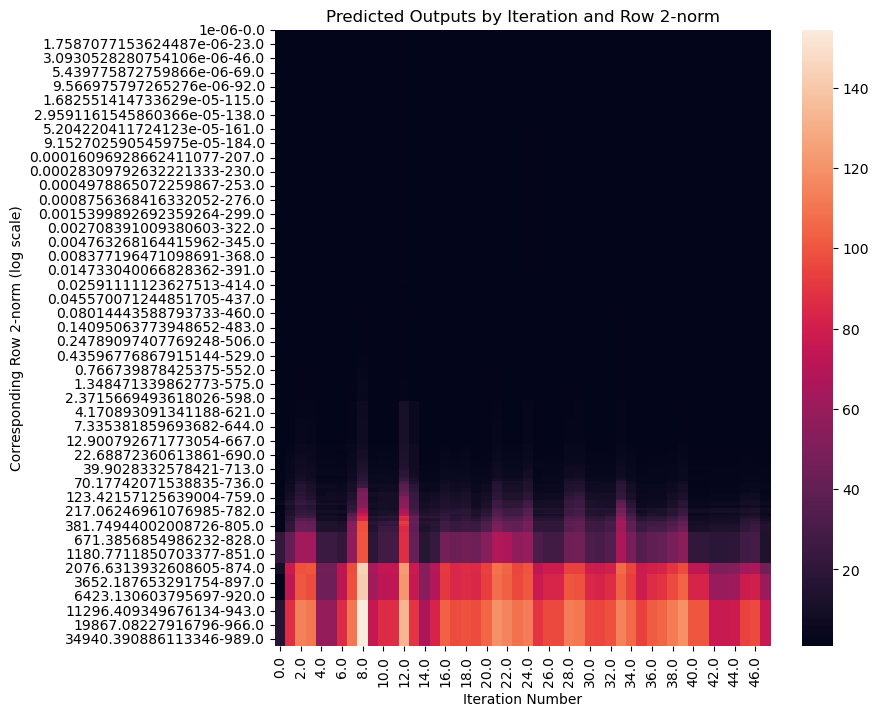

In [10]:
plt.gcf().set_size_inches(8, 8)
plt.gcf().set_dpi(100)

ax = sns.heatmap(df_spaced_piv, vmin=1, vmax=df_spaced_piv.max().max())

plt.title("Predicted Outputs by Iteration and Row 2-norm")
plt.xlabel("Iteration Number")
plt.ylabel("Corresponding Row 2-norm (log scale)")
plt.savefig(f"./figures/{matrix}/iter_r2n_output.png")
plt.show()

In [11]:
df_piv = df.pivot(index=["rowid"], columns="i", values="output")

protections = df_piv.to_numpy()
df_piv.head()

i,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0
rowid,,,,,,,,,,,,,,,,,,,,,
0.0,1.638073,3.142300,5.951646,5.101652,2.540766,2.559807,2.422331,4.451766,9.919158,2.625103,...,2.614321,3.536781,1.987968,1.987968,2.001526,2.001526,2.001526,2.220279,2.208333,1.943158
1.0,-1.301387,3.582938,13.013169,10.068865,4.249557,4.268597,3.819333,8.878519,21.987366,4.735456,...,4.883685,7.805107,2.172270,2.172270,2.779849,2.779849,2.779849,4.057500,4.475997,2.966702
2.0,1.630610,4.705222,10.125150,7.739563,3.503688,3.522729,3.073464,7.417586,19.240793,4.558880,...,3.660478,5.513446,2.567444,2.567444,2.773275,2.773275,2.773275,2.992028,2.980082,2.714906
3.0,21.689455,40.228848,62.709145,62.364513,24.459101,24.390394,20.916475,56.397644,99.565598,18.133070,...,47.621464,55.309021,21.348989,21.348989,17.833818,17.833818,19.350359,26.775209,29.000244,13.205390
4.0,21.689455,40.228848,62.709145,62.364513,24.459101,24.390394,20.916475,56.397644,99.565598,18.133070,...,47.621464,55.309021,21.348989,21.348989,17.833818,17.833818,19.350359,26.775209,29.000244,13.205390


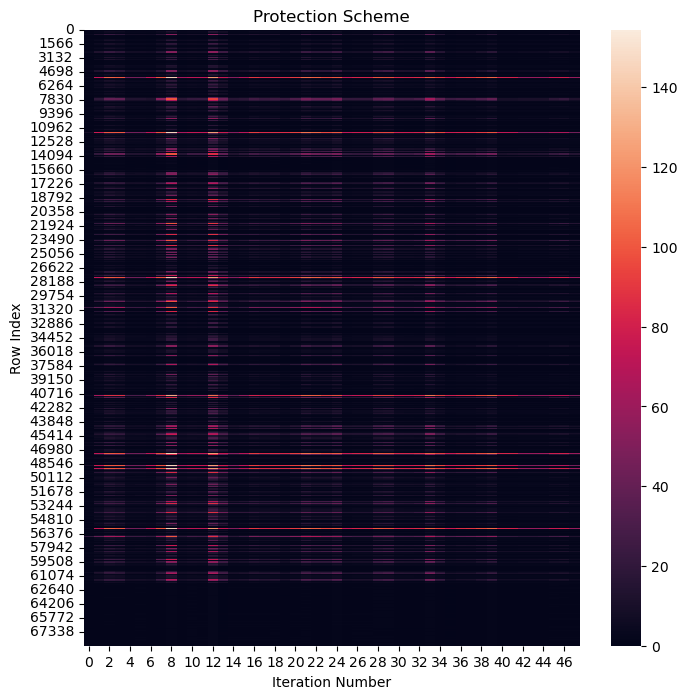

In [12]:
plt.gcf().set_size_inches(8, 8)
plt.gcf().set_dpi(100)
sns.heatmap(protections, vmin=0, vmax=protections.max())
plt.title("Protection Scheme")
plt.xlabel("Iteration Number")
plt.ylabel("Row Index")
plt.savefig(f"./figures/{matrix}/iter_row_output.png")
plt.show()